In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
from matplotlib.colors import Normalize 

%matplotlib inline

### Reading in, filtering, and examining the heart attack cost disparities data

In [2]:
# your path to the data file may vary!

ha_costs_df = pd.read_csv('../data/mmd_heart_attack_data.csv') 
tn_ha_costs = ha_costs_df.loc[ha_costs_df.state == 'TENNESSEE']
print(tn_ha_costs.shape)
print(tn_ha_costs.head(2))

(91, 17)
      year geography             measure         adjustment      analysis  \
2030  2017    County  Average total cost  Unsmoothed actual  Base measure   
2031  2017    County  Average total cost  Unsmoothed actual  Base measure   

                          domain                    condition primary_sex  \
2030  Primary chronic conditions  Acute myocardial infarction         All   
2031  Primary chronic conditions  Acute myocardial infarction         All   

     primary_age     primary_dual   fips           county      state  urban  \
2030         All  Dual & non-dual  47001  Anderson County  TENNESSEE  Urban   
2031         All  Dual & non-dual  47003   Bedford County  TENNESSEE  Rural   

     primary_race primary_denominator  analysis_value  
2030          All           undefined           42749  
2031          All           undefined           43661  


### Now getting the cancer data

In [3]:
cancer_costs_df = pd.read_csv('../data/mmd_cancer_data.csv')
tn_cancer_costs = cancer_costs_df.loc[cancer_costs_df.state == 'TENNESSEE']
print(tn_cancer_costs.shape)
print(tn_cancer_costs.head(2))

(95, 17)
      year geography             measure         adjustment      analysis  \
2396  2017    County  Average total cost  Unsmoothed actual  Base measure   
2397  2017    County  Average total cost  Unsmoothed actual  Base measure   

                          domain                                   condition  \
2396  Primary chronic conditions  Cancer, Colorectal, Breast, Prostate, Lung   
2397  Primary chronic conditions  Cancer, Colorectal, Breast, Prostate, Lung   

     primary_sex primary_age     primary_dual   fips           county  \
2396         All         All  Dual & non-dual  47001  Anderson County   
2397         All         All  Dual & non-dual  47003   Bedford County   

          state  urban primary_race primary_denominator  analysis_value  
2396  TENNESSEE  Urban          All           undefined           15454  
2397  TENNESSEE  Rural          All           undefined           19219  


### Getting the income data and cleaning it a bit

In [4]:
income_df = pd.read_csv('../data/irs_county_2016.csv')
tn_income = income_df.loc[income_df.STATE == 'TN']
tn_income.head(2)

,STATEFIPS,STATE,COUNTYFIPS,COUNTYNAME,agi_stub,N1,mars1,MARS2,MARS4,PREP,...,N10300,A10300,N85530,A85530,N85300,A85300,N11901,A11901,N11902,A11902
19752,47,TN,0,Tennessee,1,39580,22400,14440,980,25390,...,6760,17669,200,287,0,0,3970,7167,16170,59567
19753,47,TN,0,Tennessee,2,439770,345410,39920,49300,188490,...,109250,62045,0,0,0,0,37380,18477,366150,366510


In [5]:
tn_income = tn_income[['STATE', 'COUNTYNAME', 'agi_stub', 'N1', 'mars1', 'MARS2', 'MARS4', 'N2', 'NUMDEP', 'ELDERLY', 'A00100', 'N02650', 'A02650', 'N02300', 'A02300']]
tn_income.columns = ['state', 'county', 'income_bucket', 'return_count', 'single_returns', 'joint_returns', 'head_of_house_returns', 'exemptions', 'dependents', 'elderly', 'agi', 'returns_with_total_inc','total_inc_amt', 'returns_with_unemployment', 'unemployment_comp']


### Week two coding tasks
#### Replacing coded values in the `income_bucket` column with descriptive text
- create a dictionary mapping codes to descriptions
- use `replace()` to update the df with text

In [6]:
income_dict = {0:'Total', 1: 'Under $1', 2: 'Between 1 and $10,000', 3: 'Between 10,000 and $25,000',
              4: 'Between 25,000 and $50,000', 5: 'Between 50,000 and $75,000', 
               6: 'Between 75,000 and $100,000', 7: 'Between 100,000 and $200,000', 
               8:'$200,000 or more'}

In [7]:
tn_income.income_bucket = tn_income.income_bucket.replace(income_dict)
tn_income.head(2)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp
19752,TN,Tennessee,Under $1,39580,22400,14440,980,60360,8230,19090,-2747555,29090,-2710342,90,348
19753,TN,Tennessee,"Between 1 and $10,000",439770,345410,39920,49300,443540,108380,74190,2366417,439780,2441687,4830,12132


#### Creating a new df that aggregates by county to get the totals for each county

In [8]:
income_county_agg = tn_income.groupby('county').agg('sum').reset_index()
income_county_agg.head(2)

,county,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp
0,Anderson County,34290,14990,14030,4550,65950,19620,9670,1807309,34140,1830482,700,2452
1,Bedford County,20920,8600,8010,3910,43550,15790,4430,971152,20840,985909,410,1023


In [9]:
income_county_agg['avg_income'] = round(income_county_agg.total_inc_amt * 1000 / income_county_agg.returns_with_total_inc, 0)
income_county_agg.head(3)

,county,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp,avg_income
0,Anderson County,34290,14990,14030,4550,65950,19620,9670,1807309,34140,1830482,700,2452,53617.0
1,Bedford County,20920,8600,8010,3910,43550,15790,4430,971152,20840,985909,410,1023,47308.0
2,Benton County,6610,2660,2840,1000,13020,3890,2000,269227,6580,272971,360,1119,41485.0


### Week 4 Coding Tasks

#### Check for missing values

In [10]:
income_county_agg.isna().sum()

county                       0
return_count                 0
single_returns               0
joint_returns                0
head_of_house_returns        0
exemptions                   0
dependents                   0
elderly                      0
agi                          0
returns_with_total_inc       0
total_inc_amt                0
returns_with_unemployment    0
unemployment_comp            0
avg_income                   0
dtype: int64

In [11]:
tn_ha_costs.isna().sum()

year                   0
geography              0
measure                0
adjustment             0
analysis               0
domain                 0
condition              0
primary_sex            0
primary_age            0
primary_dual           0
fips                   0
county                 0
state                  0
urban                  0
primary_race           0
primary_denominator    0
analysis_value         0
dtype: int64

In [12]:
tn_cancer_costs.isna().sum()

year                   0
geography              0
measure                0
adjustment             0
analysis               0
domain                 0
condition              0
primary_sex            0
primary_age            0
primary_dual           0
fips                   0
county                 0
state                  0
urban                  0
primary_race           0
primary_denominator    0
analysis_value         0
dtype: int64

#### Create a barplot that shows the average income for each county. Be sure your plot stands alone and is labeled to identify any units.



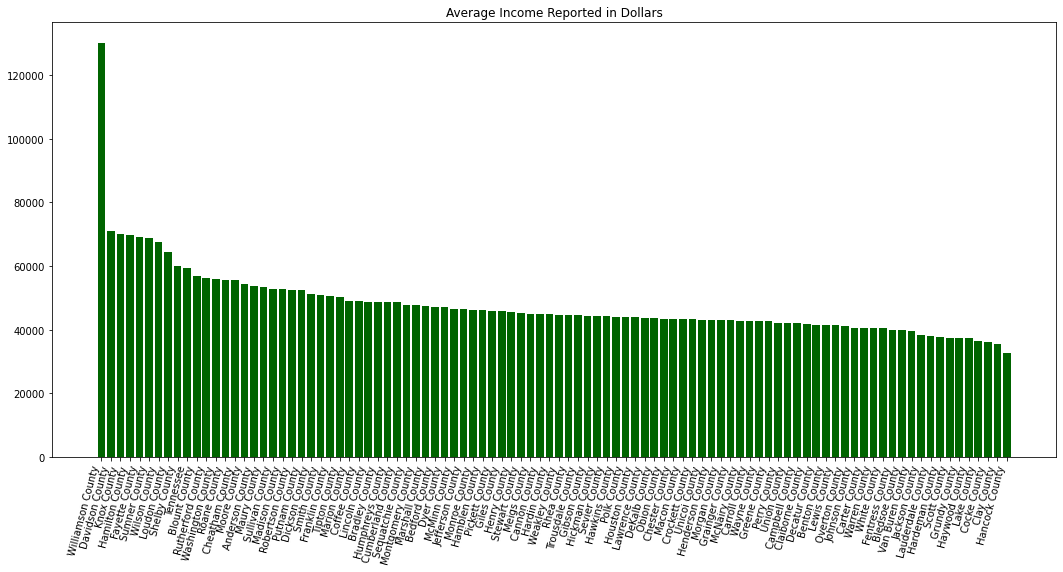

In [13]:
#sorting first by what we want to plot (average income)
income_county_agg = income_county_agg.sort_values('avg_income', ascending = False) 

plt.figure(figsize = (18, 8))
plt.bar(income_county_agg.county, income_county_agg.avg_income, color = 'darkgreen')
plt.title('Average Income Reported in Dollars')
plt.xticks(rotation = 75, ha = 'right');

In [14]:
tn_ha_costs = tn_ha_costs.sort_values('analysis_value', ascending = False)
tn_cancer_costs = tn_cancer_costs.sort_values('analysis_value', ascending = False)

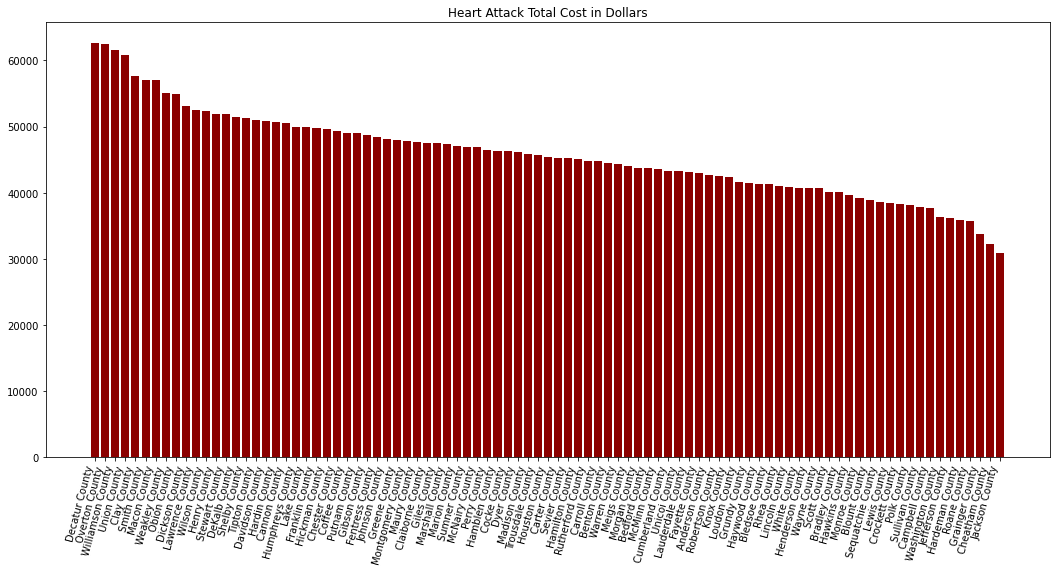

In [15]:
plt.figure(figsize = (18, 8))
plt.bar(tn_ha_costs.county, tn_ha_costs.analysis_value, color = 'darkred')
plt.title('Heart Attack Total Cost in Dollars')
plt.xticks(rotation = 75, ha = 'right');

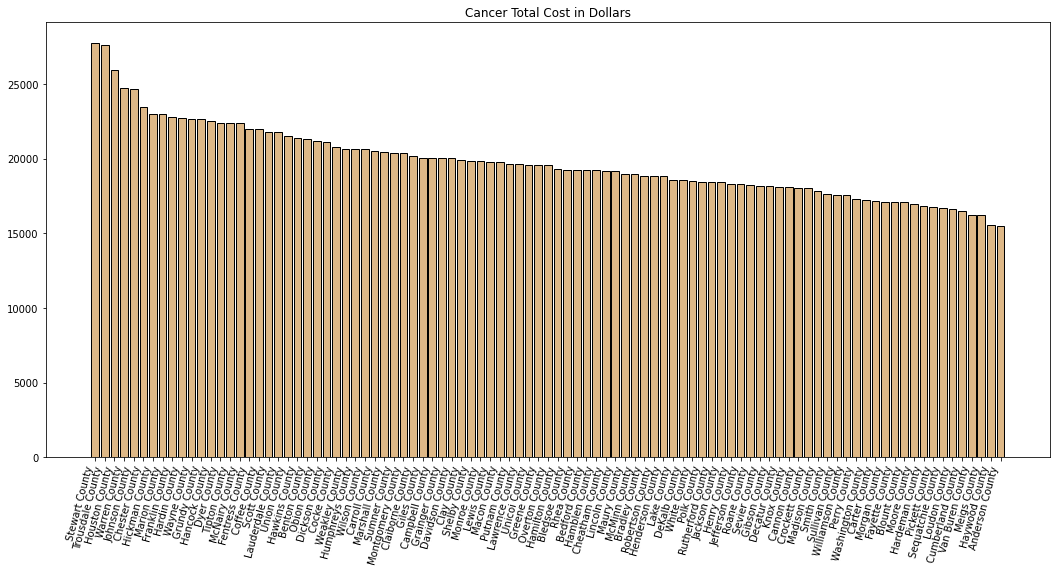

In [16]:
plt.figure(figsize = (18, 8))
plt.bar(tn_cancer_costs.county, tn_cancer_costs.analysis_value, color = 'burlywood', edgecolor = 'black')
plt.title('Cancer Total Cost in Dollars')
plt.xticks(rotation = 75, ha = 'right');

### Create a merged DataFrame for Heart Attack Costs and Income, keeping just `county`, `urban`, `analysis_value`, and `avg_income`; then do the same for Cancer Costs

In [17]:
# we only need the county and the average income from income_county_agg
county_incomes = income_county_agg[['county', 'avg_income']]
county_incomes.head(2)

,county,avg_income
94,Williamson County,130072.0
18,Davidson County,71028.0


In [18]:
# we only need county, urban, and analysis_value columns from the heart attack costs
tn_ha_costs = tn_ha_costs[['county', 'urban', 'analysis_value']]

In [19]:
tn_ha_costs2 = pd.merge(tn_ha_costs, county_incomes, on= 'county', how = 'left')
tn_ha_costs2.head(2)

,county,urban,analysis_value,avg_income
0,Decatur County,Rural,62641,41512.0
1,Overton County,Rural,62486,41100.0


In [20]:
tn_ha_costs2['cost_income_ratio'] = tn_ha_costs2.analysis_value / tn_ha_costs2.avg_income
tn_ha_costs2.describe()

,analysis_value,avg_income,cost_income_ratio
count,91.000000,91.000000,91.000000
mean,45762.989011,48059.109890,0.986273
std,6574.670462,11859.019531,0.214552
min,30831.000000,35658.000000,0.473130
25%,41105.500000,42358.500000,0.850326
50%,45384.000000,44666.000000,1.001318
75%,49698.500000,50494.500000,1.117770
max,62641.000000,130072.000000,1.618290


In [21]:
# we only need county, urban, and analysis_value columns from the cancer costs
tn_cancer_costs = tn_cancer_costs[['county', 'urban', 'analysis_value']]

In [22]:
tn_cancer_costs2 = pd.merge(tn_cancer_costs, county_incomes, on= 'county', how = 'left')
tn_cancer_costs2.head(2)

,county,urban,analysis_value,avg_income
0,Stewart County,Urban,27740,45266.0
1,Trousdale County,Urban,27602,44579.0


In [23]:
tn_cancer_costs2['cost_income_ratio'] = tn_cancer_costs2.analysis_value / tn_cancer_costs2.avg_income
tn_cancer_costs2.describe()

,analysis_value,avg_income,cost_income_ratio
count,95.000000,95.000000,95.000000
mean,19757.894737,47854.631579,0.430497
std,2436.304533,11760.400939,0.097032
min,15454.000000,32717.000000,0.134748
25%,18103.500000,42051.500000,0.362230
50%,19563.000000,44666.000000,0.428809
75%,21153.000000,50494.500000,0.480751
max,27740.000000,130072.000000,0.688174


### Comparing urban and rural costs

In [24]:
urban_ha = tn_ha_costs2.loc[tn_ha_costs2.urban == 'Urban'].sort_values('cost_income_ratio', ascending = False)
rural_ha = tn_ha_costs2.loc[tn_ha_costs2.urban == 'Rural'].sort_values('cost_income_ratio', ascending = False)

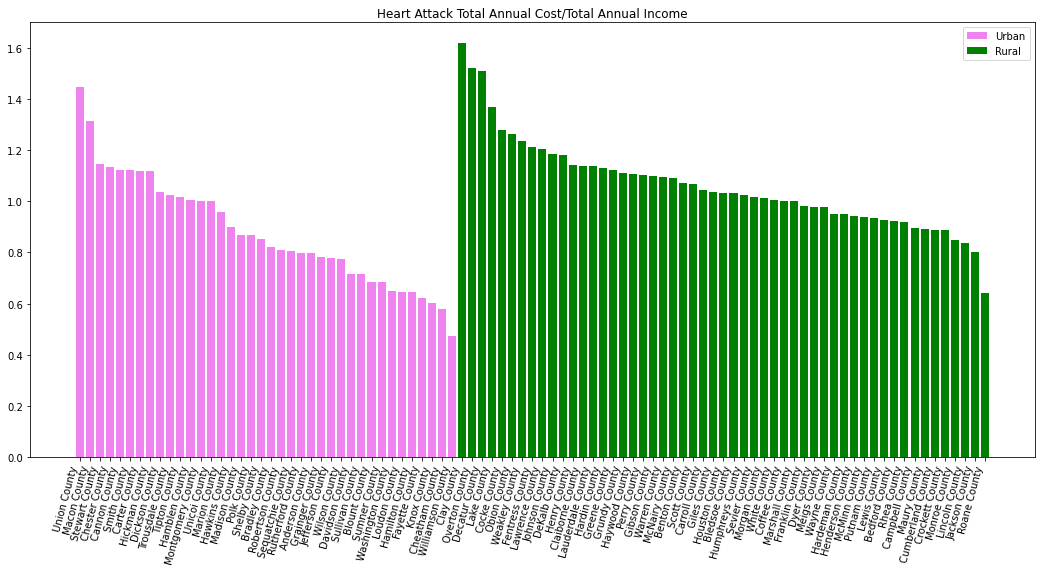

In [25]:
plt.figure(figsize = (18, 8))
plt.bar(urban_ha.county, urban_ha.cost_income_ratio, color = 'violet')
plt.bar(rural_ha.county, rural_ha.cost_income_ratio, color = 'green')
plt.title('Heart Attack Total Annual Cost/Total Annual Income')
plt.legend(['Urban', 'Rural'])
plt.xticks(rotation = 75, ha = 'right');

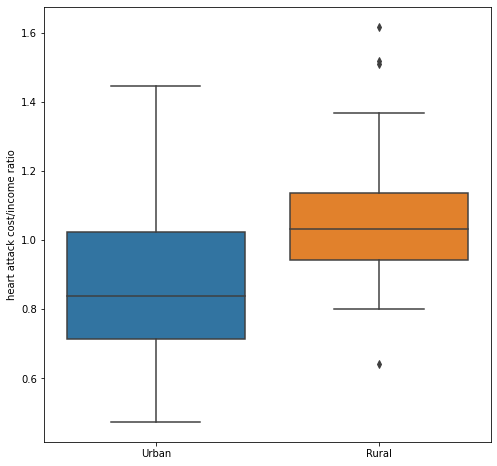

In [26]:
plt.figure(figsize = (8, 8))

sns.boxplot(x = tn_ha_costs2.urban, y = tn_ha_costs2.cost_income_ratio, order=["Urban", "Rural"])
plt.xlabel("")
plt.ylabel('heart attack cost/income ratio');

In [27]:
urban_cancer = tn_cancer_costs2.loc[tn_cancer_costs2.urban == 'Urban'].sort_values('cost_income_ratio', ascending = False)
rural_cancer = tn_cancer_costs2.loc[tn_cancer_costs2.urban == 'Rural'].sort_values('cost_income_ratio', ascending = False)

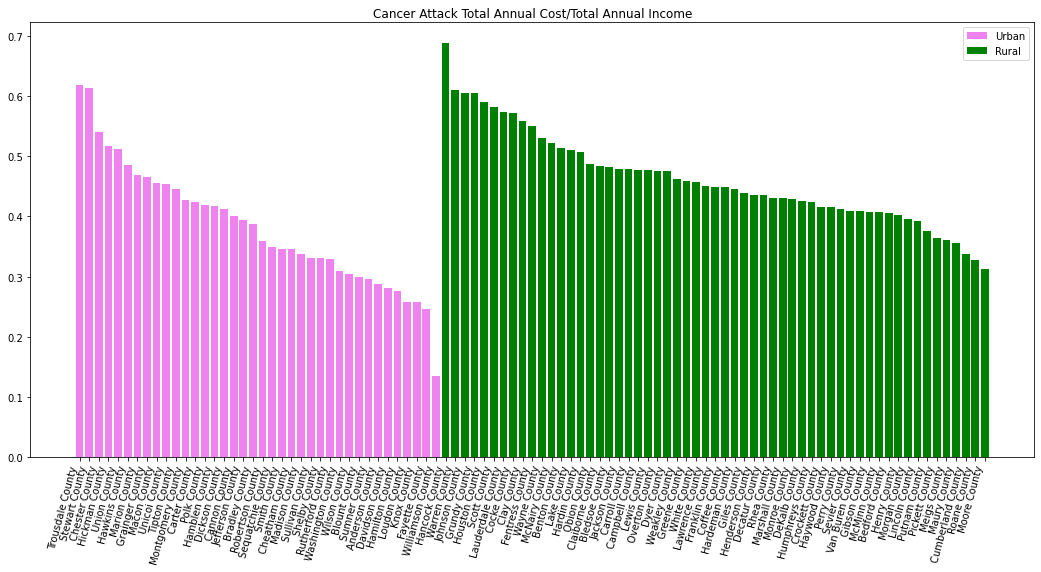

In [28]:
plt.figure(figsize = (18, 8))
plt.bar(urban_cancer.county, urban_cancer.cost_income_ratio, color = 'violet')
plt.bar(rural_cancer.county, rural_cancer.cost_income_ratio, color = 'green')
plt.title('Cancer Attack Total Annual Cost/Total Annual Income')
plt.legend(['Urban', 'Rural'])
plt.xticks(rotation = 75, ha = 'right');

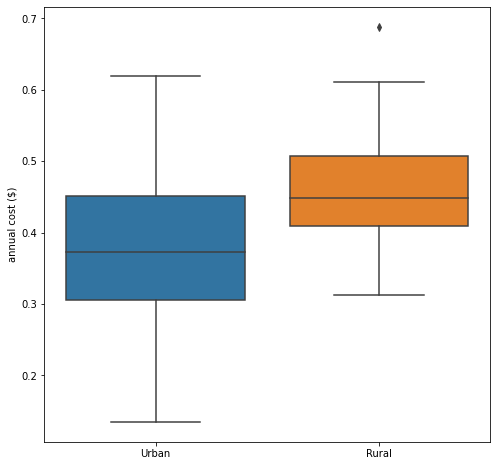

In [29]:
plt.figure(figsize = (8, 8))

sns.boxplot(x = tn_cancer_costs2.urban, y = tn_cancer_costs2.cost_income_ratio, order=["Urban", "Rural"])
plt.xlabel("")
plt.ylabel('annual cost ($)');

In [30]:
print(len(tn_cancer_costs2.analysis_value))
print(len(tn_ha_costs2.analysis_value))

95
91


In [31]:
tn_cancer_costs2.loc[~tn_cancer_costs2.county.isin(tn_ha_costs2.county)]

,county,urban,analysis_value,avg_income,cost_income_ratio
12,Hancock County,Rural,22515,32717.0,0.688174
85,Moore County,Rural,16978,54317.0,0.312572
87,Pickett County,Rural,16768,46015.0,0.364403
91,Van Buren County,Rural,16244,39762.0,0.408531


In [32]:
tn_cancer_costs3 = tn_cancer_costs2.drop(index = [12, 85, 87, 91])

In [37]:
print(tn_ha_costs2.head())

              county  urban  analysis_value  avg_income  cost_income_ratio
0     Decatur County  Rural           62641     41512.0           1.508985
1     Overton County  Rural           62486     41100.0           1.520341
2  Williamson County  Urban           61541    130072.0           0.473130
3       Union County  Urban           60785     42048.0           1.445610
4        Clay County  Rural           57705     35658.0           1.618290


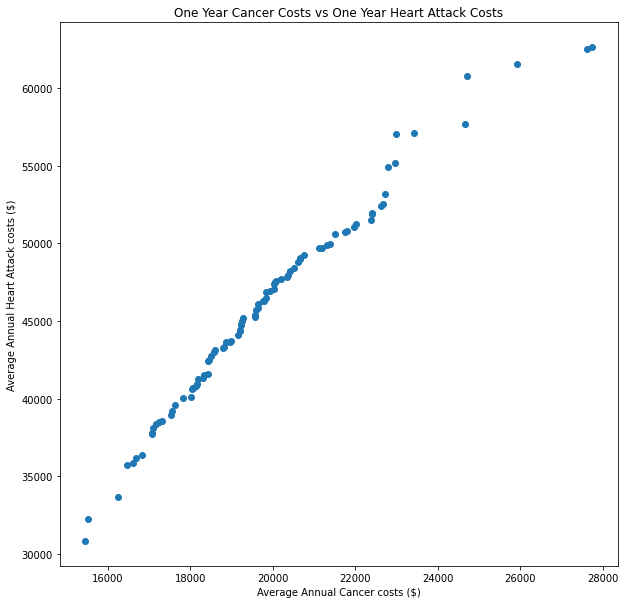

In [33]:
plt.figure(figsize = (10, 10))

plt.scatter(tn_cancer_costs3.analysis_value, tn_ha_costs2.analysis_value, marker = 'o')
plt.title('One Year Cancer Costs vs One Year Heart Attack Costs')
plt.xlabel('Average Annual Cancer costs ($)')
plt.ylabel('Average Annual Heart Attack costs ($)');

### choropleth time!


In [77]:
counties = gpd.read_file('../data/tncounty/tncounty.shp')
counties.head(2)

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762302732 344601.6428789578,..."
1,77,Wayne,47181,2.050741e+10,666520.678598,"POLYGON ((1365052.057184977 391716.8055382015,..."


In [78]:
counties.crs

{'datum': 'NAD83',
 'lat_0': 34.33333333333334,
 'lat_1': 35.25,
 'lat_2': 36.41666666666666,
 'lon_0': -86,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 600000,
 'y_0': 0}

In [80]:
counties = counties.to_crs(epsg = 4326)
counties.crs

{'init': 'epsg:4326', 'no_defs': True}

### First we'll make map the counties with a _qualitative_ color map

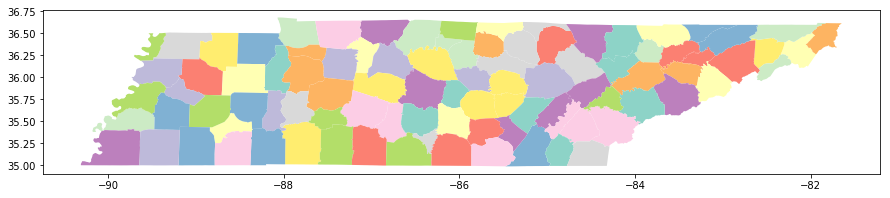

In [81]:
fig, ax = plt.subplots(figsize = (15, 8))
counties.plot(ax = ax, column = 'NAME', cmap = 'Set3');

### Next we'll merge the cancer data with the county GeoDataFrame

In [40]:
# first we drop the word *County* from the cancer data using string slicing
tn_cancer_costs2.county = tn_cancer_costs2.county.str[:-7]

# now we can merge, making sure the counties GeoDataFrame is on the left so our result is a GeoDataFrame
geo_cancer = pd.merge(counties, tn_cancer_costs2, left_on = 'NAME', right_on = 'county')
geo_cancer.head(2)

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry,county,urban,analysis_value,avg_income,cost_income_ratio
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((-88.7817680003228 35.24758800000228,...",Chester,Urban,23421,43408.0,0.539555
1,77,Wayne,47181,2.050741e+10,666520.678598,POLYGON ((-88.02474200019356 35.39230699964328...,Wayne,Rural,22658,42781.0,0.529628


### Now a choropleth of cancer cost/income ratios
 - Set up a normalized _sequential_ color map for our chorlopleth
 - define the fig and ax
 - create a divider for the colorbar (because the default legend is wacky)
 - draw the map

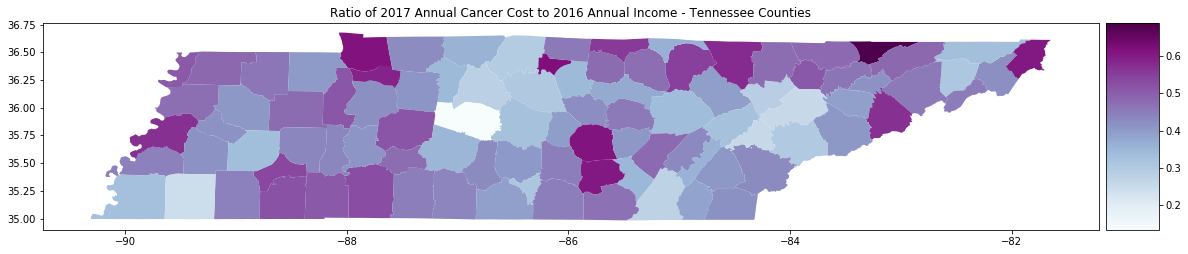

In [82]:
cmap = cm.ScalarMappable(
      norm = Normalize(geo_cancer.cost_income_ratio.min(), geo_cancer.cost_income_ratio.max()), 
      cmap = 'BuPu')
cmap.set_array([]) 

fig, ax = plt.subplots(figsize = (20, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(mappable=cmap, cax = cax)
geo_cancer.plot(ax = ax, column = 'cost_income_ratio', cmap = 'BuPu')
ax.set_title('Ratio of 2017 Annual Cancer Cost to 2016 Annual Income - Tennessee Counties');